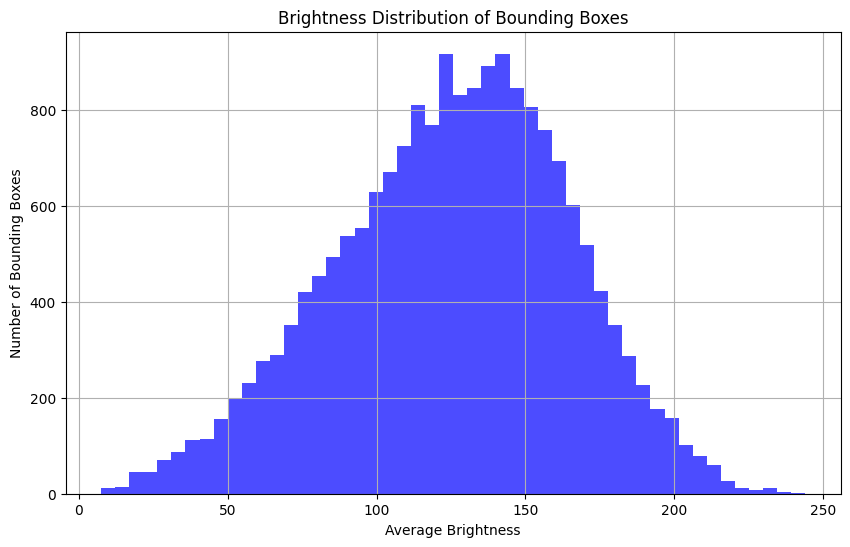

In [5]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# JSON 파일 로드
with open('cleaning_train_fold.json') as f:
    data = json.load(f)

# 이미지가 저장된 폴더 경로
image_folder = '/data/ephemeral/home/dataset/'  # train 폴더가 있는 경로

def get_bbox_brightness(image, bbox):
    """
    바운딩 박스 내의 밝기를 계산하고 반환.
    """
    x, y, w, h = bbox
    cropped_image = image[y:y+h, x:x+w]
    
    # 이미지가 RGB이면 그레이스케일로 변환
    if len(cropped_image.shape) == 3:
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    
    # 밝기의 평균 계산
    avg_brightness = np.mean(cropped_image)
    return avg_brightness

# 모든 바운딩 박스의 밝기 값을 저장할 리스트
brightness_values = []

# 바운딩 박스 밝기 계산
for item in data['images']:
    image_filename = item['file_name']
    
    # 이미지 경로를 올바르게 설정 (JSON에 저장된 이미지 경로에 train 폴더 추가)
    image_path = os.path.join(image_folder, image_filename)
    
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    if image is not None:
        for ann in data['annotations']:
            if ann['image_id'] == item['id']:
                bbox = ann['bbox']
                x, y, w, h = map(int, bbox)  # 바운딩 박스 좌표
                brightness = get_bbox_brightness(image, (x, y, w, h))
                brightness_values.append(brightness)
    else:
        print(f"Failed to load image at {image_path}")

# 밝기 값 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=50, color='blue', alpha=0.7)
plt.title('Brightness Distribution of Bounding Boxes')
plt.xlabel('Average Brightness')
plt.ylabel('Number of Bounding Boxes')
plt.grid(True)
plt.show()


## 밝기 이상치 제거


In [7]:
import os
import json
import cv2
import numpy as np

# JSON 파일 로드
with open('cleaning_train_fold.json') as f:
    data = json.load(f)

# 이미지가 저장된 폴더 경로
image_folder = '/data/ephemeral/home/dataset/'  # train 폴더 경로 설정

def get_bbox_brightness(image, bbox):
    """
    바운딩 박스 내의 밝기를 계산하고 반환.
    """
    x, y, w, h = bbox
    cropped_image = image[y:y+h, x:x+w]
    
    # 이미지가 RGB이면 그레이스케일로 변환
    if len(cropped_image.shape) == 3:
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    
    # 밝기의 평균 계산
    avg_brightness = np.mean(cropped_image)
    return avg_brightness

# 모든 바운딩 박스의 밝기 값을 저장할 리스트
brightness_values = []
annotations_filtered = []

# 바운딩 박스 밝기 계산 및 필터링을 위한 데이터 저장
for item in data['images']:
    image_filename = item['file_name']
    
    # 이미지 경로를 설정 (JSON에 저장된 이미지 경로에 train 폴더 추가)
    image_path = os.path.join(image_folder, image_filename)
    
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    if image is not None:
        for ann in data['annotations']:
            if ann['image_id'] == item['id']:
                bbox = ann['bbox']
                x, y, w, h = map(int, bbox)  # 바운딩 박스 좌표
                brightness = get_bbox_brightness(image, (x, y, w, h))
                brightness_values.append(brightness)
                
                # 바운딩 박스 정보에 밝기 추가
                ann['brightness'] = brightness
    else:
        print(f"Failed to load image at {image_path}")

# IQR 계산 및 이상치 제거 기준 설정
Q1 = np.percentile(brightness_values, 25)
Q3 = np.percentile(brightness_values, 75)
IQR = Q3 - Q1

# 이상치의 기준: Q1 - 1.5*IQR 보다 작거나, Q3 + 1.5*IQR 보다 큰 값
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 필터링
filtered_annotations = [ann for ann in data['annotations'] if lower_bound <= ann['brightness'] <= upper_bound]

# 필터링된 이미지 ID로 새로운 이미지 리스트 생성
filtered_image_ids = set([ann['image_id'] for ann in filtered_annotations])
filtered_images = [img for img in data['images'] if img['id'] in filtered_image_ids]

# 새 JSON 데이터 생성
filtered_data = {
    'images': filtered_images,
    'annotations': filtered_annotations
}

# 새 JSON 파일 저장
with open('filtered_train_fold.json', 'w') as f:
    json.dump(filtered_data, f)

print(f"Original number of annotations: {len(data['annotations'])}")
print(f"Filtered number of annotations: {len(filtered_annotations)}")


Original number of annotations: 18607
Filtered number of annotations: 18573


Mean number of bounding boxes per image: 4.760040931184446
Lower bound for outliers: -6.5
Upper bound for outliers: 13.5


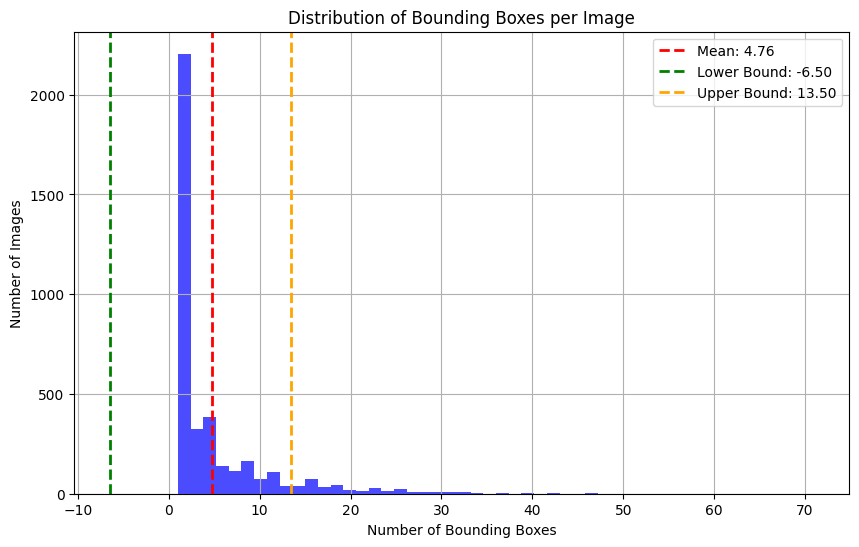

Number of outlier images: 356


In [8]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# JSON 파일 로드
with open('cleaning_train_fold.json') as f:
    data = json.load(f)

# 각 이미지별 바운딩 박스 개수 계산
image_bbox_count = {}

# 바운딩 박스 개수 카운트
for item in data['images']:
    image_id = item['id']
    
    # 해당 이미지의 바운딩 박스 개수 카운트
    bbox_count = sum(1 for ann in data['annotations'] if ann['image_id'] == image_id)
    
    # 이미지 ID별 바운딩 박스 개수 저장
    image_bbox_count[image_id] = bbox_count

# 바운딩 박스 개수 리스트 추출
bbox_counts = list(image_bbox_count.values())

# 바운딩 박스 개수의 평균 계산
mean_bbox_count = np.mean(bbox_counts)
print(f"Mean number of bounding boxes per image: {mean_bbox_count}")

# IQR 계산
Q1 = np.percentile(bbox_counts, 25)
Q3 = np.percentile(bbox_counts, 75)
IQR = Q3 - Q1

# 이상치의 기준: Q1 - 1.5*IQR 보다 작거나, Q3 + 1.5*IQR 보다 큰 값
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound for outliers: {lower_bound}")
print(f"Upper bound for outliers: {upper_bound}")

# 바운딩 박스 개수 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(bbox_counts, bins=50, color='blue', alpha=0.7)
plt.axvline(mean_bbox_count, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_bbox_count:.2f}')
plt.axvline(lower_bound, color='green', linestyle='dashed', linewidth=2, label=f'Lower Bound: {lower_bound:.2f}')
plt.axvline(upper_bound, color='orange', linestyle='dashed', linewidth=2, label=f'Upper Bound: {upper_bound:.2f}')
plt.title('Distribution of Bounding Boxes per Image')
plt.xlabel('Number of Bounding Boxes')
plt.ylabel('Number of Images')
plt.legend()
plt.grid(True)
plt.show()

# 이상치에 해당하는 이미지 ID 확인
outlier_images = [img_id for img_id, count in image_bbox_count.items() if count < lower_bound or count > upper_bound]
print(f"Number of outlier images: {len(outlier_images)}")


In [9]:
import os
import json

# JSON 파일 로드
with open('cleaning_train_fold.json') as f:
    data = json.load(f)

# 각 이미지별 바운딩 박스 개수 계산
image_bbox_count = {}

# 바운딩 박스 개수 카운트
for item in data['images']:
    image_id = item['id']
    
    # 해당 이미지의 바운딩 박스 개수 카운트
    bbox_count = sum(1 for ann in data['annotations'] if ann['image_id'] == image_id)
    
    # 이미지 ID별 바운딩 박스 개수 저장
    image_bbox_count[image_id] = bbox_count

# 바운딩 박스가 14개 이상인 이미지를 제외
filtered_annotations = [
    ann for ann in data['annotations'] if image_bbox_count[ann['image_id']] < 14
]

# 바운딩 박스가 14개 이상인 이미지를 제외한 이미지 리스트 생성
filtered_image_ids = set([ann['image_id'] for ann in filtered_annotations])
filtered_images = [img for img in data['images'] if img['id'] in filtered_image_ids]

# 새 JSON 데이터 생성
filtered_data = {
    'images': filtered_images,
    'annotations': filtered_annotations
}

# 새 JSON 파일 저장
output_folder = 'output'
os.makedirs(output_folder, exist_ok=True)  # 폴더가 없으면 생성
output_path = os.path.join(output_folder, 'filtered_train_fold_less_than_14_bbox.json')

with open(output_path, 'w') as f:
    json.dump(filtered_data, f)

print(f"Original number of images: {len(data['images'])}")
print(f"Filtered number of images: {len(filtered_images)}")
print(f"Filtered JSON saved to {output_path}")


Original number of images: 3909
Filtered number of images: 3553
Filtered JSON saved to output/filtered_train_fold_less_than_14_bbox.json


In [10]:
import os
import json
import cv2
import numpy as np

# JSON 파일 로드 (바운딩 박스 14개 이상 제거된 JSON 파일)
with open('filtered_train_fold_less_than_14_bbox.json') as f:
    data = json.load(f)

# 이미지가 저장된 폴더 경로
image_folder = '/data/ephemeral/home/dataset/'  # 이미지 폴더 경로 설정

def get_bbox_brightness(image, bbox):
    """
    바운딩 박스 내의 밝기를 계산하고 반환.
    """
    x, y, w, h = bbox
    cropped_image = image[y:y+h, x:x+w]
    
    # 이미지가 RGB이면 그레이스케일로 변환
    if len(cropped_image.shape) == 3:
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    
    # 밝기의 평균 계산
    avg_brightness = np.mean(cropped_image)
    return avg_brightness

# 모든 바운딩 박스의 밝기 값을 저장
brightness_values = []

# 각 이미지의 바운딩 박스 밝기 추출
for item in data['images']:
    image_filename = item['file_name']
    
    # 이미지 경로 설정
    image_path = os.path.join(image_folder, image_filename)
    
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    if image is not None:
        for ann in data['annotations']:
            if ann['image_id'] == item['id']:
                bbox = ann['bbox']
                x, y, w, h = map(int, bbox)  # 바운딩 박스 좌표
                
                brightness = get_bbox_brightness(image, (x, y, w, h))
                brightness_values.append(brightness)

# IQR 계산
Q1 = np.percentile(brightness_values, 25)
Q3 = np.percentile(brightness_values, 75)
IQR = Q3 - Q1

# IQR에 기반한 밝기 기준
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 임의의 밝기 임계값 설정
brightness_threshold = 50

# 두 가지 기준에 따른 어두운 바운딩 박스를 가진 이미지 필터링
dark_images_threshold = set()
dark_images_iqr = set()

for item in data['images']:
    image_filename = item['file_name']
    
    # 이미지 경로 설정
    image_path = os.path.join(image_folder, image_filename)
    
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    if image is not None:
        for ann in data['annotations']:
            if ann['image_id'] == item['id']:
                bbox = ann['bbox']
                x, y, w, h = map(int, bbox)  # 바운딩 박스 좌표
                brightness = get_bbox_brightness(image, (x, y, w, h))
                
                # 임의의 밝기 임계값 기준으로 필터링
                if brightness < brightness_threshold:
                    dark_images_threshold.add(item['file_name'])
                
                # IQR 기준으로 필터링
                if brightness < lower_bound or brightness > upper_bound:
                    dark_images_iqr.add(item['file_name'])

# 결과 출력
print("=== 임의의 밝기 임계값(50) 기준 ===")
print(f"어두운 바운딩 박스를 가진 이미지 수: {len(dark_images_threshold)}")
print("이미지 목록:")
for img in dark_images_threshold:
    print(img)

print("\n=== IQR 기준 ===")
print(f"어두운 바운딩 박스를 가진 이미지 수: {len(dark_images_iqr)}")
print("이미지 목록:")
for img in dark_images_iqr:
    print(img)


=== 임의의 밝기 임계값(50) 기준 ===
어두운 바운딩 박스를 가진 이미지 수: 159
이미지 목록:
train/1412.jpg
train/0761.jpg
train/4315.jpg
train/2213.jpg
train/3392.jpg
train/4859.jpg
train/0409.jpg
train/0991.jpg
train/2222.jpg
train/3395.jpg
train/1972.jpg
train/3141.jpg
train/4574.jpg
train/1788.jpg
train/2530.jpg
train/3700.jpg
train/2366.jpg
train/1133.jpg
train/4318.jpg
train/1612.jpg
train/1193.jpg
train/2323.jpg
train/2225.jpg
train/3765.jpg
train/2920.jpg
train/4565.jpg
train/0778.jpg
train/4656.jpg
train/3119.jpg
train/4626.jpg
train/0453.jpg
train/3084.jpg
train/3173.jpg
train/2096.jpg
train/1737.jpg
train/4106.jpg
train/1634.jpg
train/2963.jpg
train/0238.jpg
train/1391.jpg
train/4672.jpg
train/0792.jpg
train/0929.jpg
train/3856.jpg
train/2177.jpg
train/0268.jpg
train/0613.jpg
train/4009.jpg
train/1128.jpg
train/3414.jpg
train/1408.jpg
train/3474.jpg
train/4304.jpg
train/3756.jpg
train/4176.jpg
train/4762.jpg
train/1455.jpg
train/4669.jpg
train/4324.jpg
train/2340.jpg
train/2916.jpg
train/3954.jpg
train/3837

In [14]:
import os
import json
import cv2
import numpy as np

# JSON 파일 로드 (바운딩 박스 14개 이상 제거된 JSON 파일)
with open('filtered_train_fold_less_than_14_bbox.json') as f:
    data = json.load(f)

# 이미지가 저장된 폴더 경로
image_folder = '/data/ephemeral/home/dataset/'  # 이미지 폴더 경로 설정

def get_bbox_brightness(image, bbox):
    """
    바운딩 박스 내의 밝기를 계산하고 반환.
    """
    x, y, w, h = bbox
    cropped_image = image[y:y+h, x:x+w]
    
    # 이미지가 RGB이면 그레이스케일로 변환
    if len(cropped_image.shape) == 3:
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    
    # 밝기의 평균 계산
    avg_brightness = np.mean(cropped_image)
    return avg_brightness

# 모든 바운딩 박스의 밝기 값을 저장
brightness_values = []

# 각 이미지의 바운딩 박스 밝기 추출
for item in data['images']:
    image_filename = item['file_name']
    
    # 이미지 경로 설정
    image_path = os.path.join(image_folder, image_filename)
    
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    if image is not None:
        for ann in data['annotations']:
            if ann['image_id'] == item['id']:
                bbox = ann['bbox']
                x, y, w, h = map(int, bbox)  # 바운딩 박스 좌표
                
                brightness = get_bbox_brightness(image, (x, y, w, h))
                brightness_values.append(brightness)

# IQR 계산
Q1 = np.percentile(brightness_values, 25)
Q3 = np.percentile(brightness_values, 75)
IQR = Q3 - Q1

# IQR에 기반한 밝기 기준
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 임의의 밝기 임계값 설정
brightness_threshold = 50

# 두 가지 기준에 따른 어두운 바운딩 박스를 가진 이미지 ID 필터링
dark_images_threshold = set()
dark_images_iqr = set()

for item in data['images']:
    image_filename = item['file_name']
    
    # 이미지 경로 설정
    image_path = os.path.join(image_folder, image_filename)
    
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    if image is not None:
        for ann in data['annotations']:
            if ann['image_id'] == item['id']:
                bbox = ann['bbox']
                x, y, w, h = map(int, bbox)  # 바운딩 박스 좌표
                brightness = get_bbox_brightness(image, (x, y, w, h))
                
                # 임의의 밝기 임계값 기준으로 필터링
                if brightness < brightness_threshold:
                    dark_images_threshold.add(item['id'])
                
                # IQR 기준으로 필터링
                if brightness < lower_bound or brightness > upper_bound:
                    dark_images_iqr.add(item['id'])

# 필터링된 이미지와 어노테이션에서 이상치를 제외한 데이터 추출
filtered_annotations_threshold = [ann for ann in data['annotations'] if ann['image_id'] not in dark_images_threshold]
filtered_images_threshold = [img for img in data['images'] if img['id'] not in dark_images_threshold]

filtered_annotations_iqr = [ann for ann in data['annotations'] if ann['image_id'] not in dark_images_iqr]
filtered_images_iqr = [img for img in data['images'] if img['id'] not in dark_images_iqr]

# 이상치를 제외한 데이터를 JSON으로 저장
filtered_data_threshold = {
    'images': filtered_images_threshold,
    'annotations': filtered_annotations_threshold
}

filtered_data_iqr = {
    'images': filtered_images_iqr,
    'annotations': filtered_annotations_iqr
}

# JSON 파일로 저장
output_folder = 'output'
os.makedirs(output_folder, exist_ok=True)  # 폴더가 없으면 생성

# 임의의 밝기 임계값 기준 저장
output_path_threshold = os.path.join(output_folder, 'filtered_train_excluded_threshold_50.json')
with open(output_path_threshold, 'w') as f:
    json.dump(filtered_data_threshold, f)

# IQR 기준 저장
output_path_iqr = os.path.join(output_folder, 'filtered_train_excluded_iqr.json')
with open(output_path_iqr, 'w') as f:
    json.dump(filtered_data_iqr, f)

print(f"Filtered JSON excluding outliers based on brightness threshold (50) saved at {output_path_threshold}")
print(f"Filtered JSON excluding outliers based on IQR saved at {output_path_iqr}")


Filtered JSON excluding outliers based on brightness threshold (50) saved at output/filtered_train_excluded_threshold_50.json
Filtered JSON excluding outliers based on IQR saved at output/filtered_train_excluded_iqr.json


In [15]:
import json
import os

# JSON 파일 리스트
json_files = ['filtered_train_fold_less_than_14_bbox.json', 'filtered_train_excluded_iqr.json', 'filtered_train_excluded_threshold_50.json']

for file in json_files:
    # JSON 파일 열기
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 모든 이미지 ID 리스트
    all_image_ids = set([img['id'] for img in data['images']])

    # annotation에 사용된 이미지 ID 리스트
    used_image_ids = set([ann['image_id'] for ann in data['annotations']])

    # 사용된 이미지 개수 계산
    used_images = [img for img in data['images'] if img['id'] in used_image_ids]

    print(f"File: {file}")
    print(f"Total number of images: {len(all_image_ids)}")
    print(f"Number of images used in annotations: {len(used_images)}\n")


File: filtered_train_fold_less_than_14_bbox.json
Total number of images: 3553
Number of images used in annotations: 3553

File: filtered_train_excluded_iqr.json
Total number of images: 3502
Number of images used in annotations: 3502

File: filtered_train_excluded_threshold_50.json
Total number of images: 3394
Number of images used in annotations: 3394



In [1]:
import json
import os

# JSON 파일 경로 설정
input_path = '/data/ephemeral/home/dataset/cleandata/cleaning_train_fold.json'
output_path = 'filtered_train_less_than_14_bbox2.json'

# JSON 파일 로드
with open(input_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 각 이미지에 해당하는 바운딩 박스 개수를 저장할 딕셔너리
image_bbox_count = {}

# 'annotations' 섹션에서 바운딩 박스 개수 계산
for ann in data['annotations']:
    image_id = ann['image_id']
    if image_id in image_bbox_count:
        image_bbox_count[image_id] += 1
    else:
        image_bbox_count[image_id] = 1

# 바운딩 박스가 14개 미만인 이미지 ID 추출
valid_image_ids = {image_id for image_id, count in image_bbox_count.items() if count < 14}

# 'images' 섹션에서 바운딩 박스가 14개 미만인 이미지만 선택
filtered_images = [img for img in data['images'] if img['id'] in valid_image_ids]

# 'annotations' 섹션에서 바운딩 박스가 14개 미만인 이미지만 선택
filtered_annotations = [ann for ann in data['annotations'] if ann['image_id'] in valid_image_ids]

# 'categories' 섹션은 그대로 유지
filtered_categories = data['categories']

# 새로운 JSON 데이터 생성
filtered_data = {
    'images': filtered_images,
    'annotations': filtered_annotations,
    'categories': filtered_categories
}

# 필터링된 데이터를 JSON 파일로 저장
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(filtered_data, f, indent=4)

print(f"Filtered JSON saved to {output_path}")
print(f"Total number of images before filtering: {len(data['images'])}")
print(f"Number of images after filtering: {len(filtered_images)}")
print(f"Filtered JSON saved to {output_path}")

Filtered JSON saved to filtered_train_less_than_14_bbox2.json
Total number of images before filtering: 3909
Number of images after filtering: 3553
Filtered JSON saved to filtered_train_less_than_14_bbox2.json


In [3]:
import os
import json
import cv2
import numpy as np

# JSON 파일 로드 (바운딩 박스 14개 이상 제거된 JSON 파일)
with open('filtered_train_less_than_14_bbox2.json') as f:
    data = json.load(f)

# 이미지가 저장된 폴더 경로
image_folder = '/data/ephemeral/home/dataset/'  # 이미지 폴더 경로 설정

def get_bbox_brightness(image, bbox):
    """
    바운딩 박스 내의 밝기를 계산하고 반환.
    """
    x, y, w, h = bbox
    cropped_image = image[y:y+h, x:x+w]
    
    # 이미지가 RGB이면 그레이스케일로 변환
    if len(cropped_image.shape) == 3:
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    
    # 밝기의 평균 계산
    avg_brightness = np.mean(cropped_image)
    return avg_brightness

# 모든 바운딩 박스의 밝기 값을 저장
brightness_values = []

# 각 이미지의 바운딩 박스 밝기 추출
for item in data['images']:
    image_filename = item['file_name']
    
    # 이미지 경로 설정
    image_path = os.path.join(image_folder, image_filename)
    
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    if image is not None:
        for ann in data['annotations']:
            if ann['image_id'] == item['id']:
                bbox = ann['bbox']
                x, y, w, h = map(int, bbox)  # 바운딩 박스 좌표
                
                brightness = get_bbox_brightness(image, (x, y, w, h))
                brightness_values.append(brightness)

# IQR 계산
Q1 = np.percentile(brightness_values, 25)
Q3 = np.percentile(brightness_values, 75)
IQR = Q3 - Q1

# IQR에 기반한 밝기 기준
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 임의의 밝기 임계값 설정
brightness_threshold = 50

# 두 가지 기준에 따른 어두운 바운딩 박스를 가진 이미지 필터링
dark_images_threshold = set()
dark_images_iqr = set()

for item in data['images']:
    image_filename = item['file_name']
    
    # 이미지 경로 설정
    image_path = os.path.join(image_folder, image_filename)
    
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    if image is not None:
        for ann in data['annotations']:
            if ann['image_id'] == item['id']:
                bbox = ann['bbox']
                x, y, w, h = map(int, bbox)  # 바운딩 박스 좌표
                brightness = get_bbox_brightness(image, (x, y, w, h))
                
                # 임의의 밝기 임계값 기준으로 필터링
                if brightness < brightness_threshold:
                    dark_images_threshold.add(item['id'])
                
                # IQR 기준으로 필터링
                if brightness < lower_bound or brightness > upper_bound:
                    dark_images_iqr.add(item['id'])

# 두 가지 기준에 따라 필터링된 이미지와 어노테이션 추출
filtered_annotations_threshold = [ann for ann in data['annotations'] if ann['image_id'] not in dark_images_threshold]
filtered_images_threshold = [img for img in data['images'] if img['id'] not in dark_images_threshold]

filtered_annotations_iqr = [ann for ann in data['annotations'] if ann['image_id'] not in dark_images_iqr]
filtered_images_iqr = [img for img in data['images'] if img['id'] not in dark_images_iqr]

# 'categories' 섹션은 그대로 유지
filtered_categories = data['categories']

# 임의의 밝기 임계값 기준으로 필터링된 데이터를 JSON으로 저장
filtered_data_threshold = {
    'images': filtered_images_threshold,
    'annotations': filtered_annotations_threshold,
    'categories': filtered_categories
}

filtered_data_iqr = {
    'images': filtered_images_iqr,
    'annotations': filtered_annotations_iqr,
    'categories': filtered_categories
}

# JSON 파일로 저장
output_folder = 'output'
os.makedirs(output_folder, exist_ok=True)  # 폴더가 없으면 생성

# 임의의 밝기 임계값 기준 저장
output_path_threshold = os.path.join(output_folder, 'filtered_train_threshold_50.json')
with open(output_path_threshold, 'w', encoding='utf-8') as f:
    json.dump(filtered_data_threshold, f, indent=4)

# IQR 기준 저장
output_path_iqr = os.path.join(output_folder, 'filtered_train_iqr.json')
with open(output_path_iqr, 'w', encoding='utf-8') as f:
    json.dump(filtered_data_iqr, f, indent=4)

# 필터링된 이미지 개수 출력
print(f"Total number of images before filtering: {len(data['images'])}")
print(f"Number of images after filtering (brightness threshold): {len(filtered_images_threshold)}")
print(f"Number of images after filtering (IQR): {len(filtered_images_iqr)}")
print(f"Filtered JSON saved based on brightness threshold (50) at {output_path_threshold}")
print(f"Filtered JSON saved based on IQR at {output_path_iqr}")


Total number of images before filtering: 3553
Number of images after filtering (brightness threshold): 3394
Number of images after filtering (IQR): 3502
Filtered JSON saved based on brightness threshold (50) at output/filtered_train_threshold_50.json
Filtered JSON saved based on IQR at output/filtered_train_iqr.json
